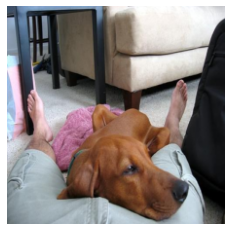

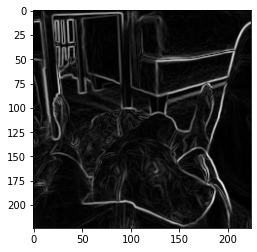

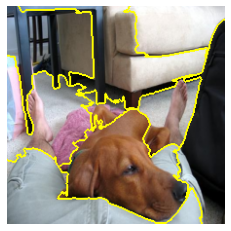

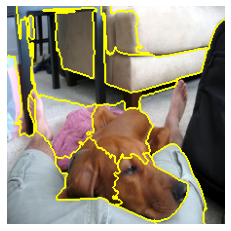

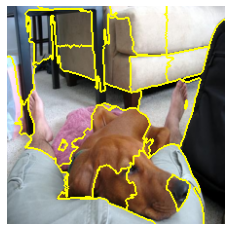

In [1]:
# import the necessary packages
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import torchvision
import torch
import random
import torch.nn as nn
import litdata
from skimage.filters import sobel
from skimage.color import rgb2gray


postprocess = (
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), 
        #torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    nn.Identity(),
    )

train_dataset = litdata.LITDataset(
            "IN1k",
            r"F:\data",
            override_extensions=[
                'jpg',
                'cls'
            ],
            train = True,
        ).map_tuple(*postprocess)

# Load CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='F:\data', train=True, download=False, transform=torchvision.transforms.Resize((224, 224)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Select a random image from the data loader
random_index = 3#random.randint(0, len(train_dataset) - 1)
image_raw, _ = train_dataset[random_index]

# Convert the image to a floating point data type
image = img_as_float(image_raw)

plt.imshow(image)
plt.axis("off")
plt.show()

gradient = sobel(rgb2gray(image))
plt.imshow(gradient, cmap='gray')

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply Watershed and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of Watershed
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

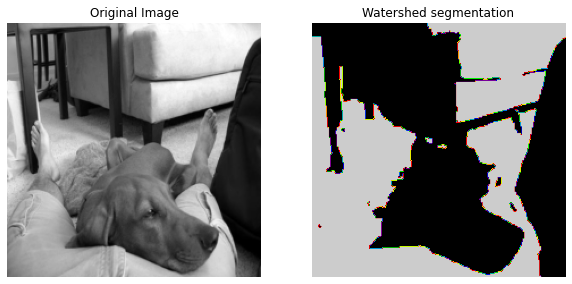

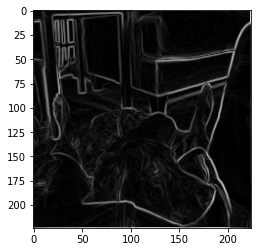

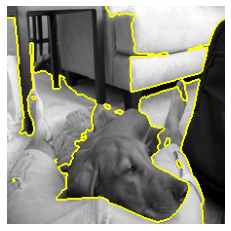

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn.functional as F
from collections import deque


def sobel_filter(image):
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 255]
    G = (G / G.max()) * 255
    
    return G.squeeze().detach().numpy().astype(np.uint8)

import numpy as np
from collections import deque
import torch
import torch.nn.functional as F
import heapq

def watershed_from_scratch(image, lower_percentile=30, upper_percentile=70):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)

    # Generate markers based on the given percentiles
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, lower_percentile)] = 1
    markers[image > np.percentile(image, upper_percentile)] = 2

    # Label the markers
    markers_torch = torch.tensor(markers, dtype=torch.int32)
    labeled = torch.zeros_like(markers_torch)
    
    labeled[markers_torch == 1] = 1
    labeled[markers_torch == 2] = 2

    # Simulate flooding process using a priority queue
    heap = []
    for (i, j), value in np.ndenumerate(labeled.numpy()):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))
    
    # Convert labeled back to numpy for visualization
    labeled = labeled.numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()
    
    plt.imshow(gradient, cmap='gray')
    
    # Show the output of Watershed
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, labeled))
    plt.axis("off")



watershed_from_scratch(image)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn as nn
import torch.nn.functional as F

def sobel_filter(image):
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 1]
    G = G / G.max()
    
    return G.squeeze(0).squeeze(0)

### 2. Seed Prediction Network

class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

### 3. Differentiable Watershed

def differentiable_watershed(image, seed_net):
    # Convert image to grayscale if necessary
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)
    
    # Predict seeds using the seed prediction network
    seeds = seed_net(gradient.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
    
    # Soft flooding process
    labeled = torch.zeros_like(gradient)
    height, width = gradient.shape

    for i in range(height):
        for j in range(width):
            if seeds[i, j] > 0.5:
                labeled[i, j] = 1
    
    soft_labels = F.softmax(-gradient.view(-1) / 0.1, dim=0).view(height, width)
    labeled = labeled * soft_labels
    
    return labeled, seeds

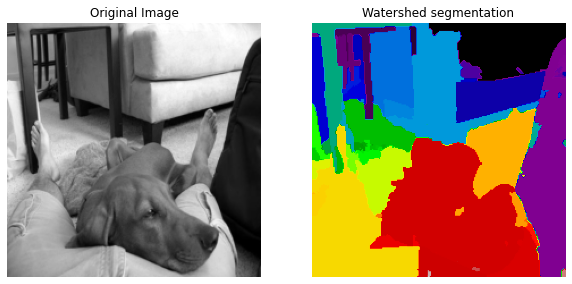

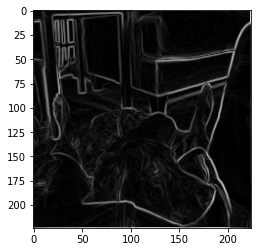

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn.functional as F


def sobel_filter(image):
    """Instead of fixed sobel kernels can we make the parameters in the kernels learnable? This could let the model learn the optimal edge detection filters"""
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 255]
    G = (G / G.max()) * 255
    
    return G.squeeze().detach().numpy().astype(np.uint8)

def generate_binary_structure(rank, connectivity):
    if connectivity < 1:
        connectivity = 1
    if rank < 1:
        return np.array(True, dtype=bool)
    output = np.fabs(np.indices([3] * rank) - 1)
    output = np.add.reduce(output, 0)
    return output <= connectivity

def connected_components(input, structure=None):
    input = np.asarray(input)
    if np.iscomplexobj(input):
        raise TypeError('Complex type not supported')

    if structure is None:
        structure = generate_binary_structure(input.ndim, 1)
    structure = np.asarray(structure, dtype=bool)
    
    if structure.ndim != input.ndim:
        raise RuntimeError('structure and input must have equal rank')
    for ii in structure.shape:
        if ii != 3:
            raise ValueError('structure dimensions must be equal to 3')

    output = np.zeros(input.shape, np.int32)
    label = 1
    max_label = 0

    def flood_fill(x, y, label):
        queue = [(x, y)]
        while queue:
            cx, cy = queue.pop(0)
            if output[cx, cy] == 0 and input[cx, cy]:
                output[cx, cy] = label
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < input.shape[0] and 0 <= ny < input.shape[1]:
                        queue.append((nx, ny))

    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            if input[i, j] and output[i, j] == 0:
                flood_fill(i, j, label)
                label += 1
                max_label = label - 1

    return output, max_label


def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)

    # Generate markers
    """
    these markers is to identifies specific regions in the image that will serve as starting points (seeds) for the watershed algorithm. In traditional watershed segmentation:
    Low-Intensity Markers (1): These typically correspond to the darker regions in the image, which could represent background or specific objects of interest.
    High-Intensity Markers (2): These typically correspond to the brighter regions in the image, which could represent different objects or features of interest.
    
    By using these markers, the watershed algorithm can "flood" the image from these predefined seed points, allowing for more controlled and accurate segmentation of different regions within the image.
    Instead of using percentiles, could we make the placement of the markers learnable instead?
    """
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    """
    The flooding process inherently involves non-differentiable operations like heap-based priority queues. 
    To make this differentiable, we can approximate the process using differentiable operations, 
    such as softmax for computing probabilities of pixel assignments.
    """
    labeled, _ = connected_components(markers)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()
    
    plt.imshow(gradient, cmap='gray')


watershed_from_scratch(image)

In [5]:
import torch
import torch.nn as nn
import quix
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torch import Tensor
from typing import Callable
from scipy.sparse.csgraph import connected_components
from scipy.sparse import coo_matrix

BivariateCallable = Callable[[Tensor,Tensor],Tensor]

class PyTorchLabeller:

    '''A simple labeling class for PyTorch image tensors.

    Attributes
    ----------
    B : int
        Batch size.
    C : int
        Channels.
    H : int
        Image height.
    W : int
        Image width.
    '''

    def __init__(self, B:int, C:int, H:int, W:int, device='cpu'):
        self.B, self.C, self.H, self.W = B, C, H, W
        self._n = B*H*W
        self._idx = torch.arange(self._n, device=device).view(B,H,W)
        lr = self._idx.unfold(-1, 2, 1).reshape(-1, 2).mT
        ud = self._idx.unfold(-2, 2, 1).reshape(-1, 2).mT
        self._edges = torch.cat([lr, ud], -1)
        self._cfirst = (B,C,H,W)
        self._clast = (B,H,W,C)

    def cc(self, src:Tensor, tgt:Tensor) -> Tensor:
        '''Computes connected components using SciPy / CPU
    
        Attributes
        ----------
        src : int 
            Source edges.
        tgt : int 
            Target edges.
            
        Returns
        -------
        Tensor: Connected components of graph.
        '''
        n = self._n
        ones = torch.ones_like(src, device='cpu').numpy()
        edges = (src.numpy(), tgt.numpy())
        csr = coo_matrix((ones, edges), shape=(n,n)).tocsr()
        return src.new_tensor(connected_components(csr)[1])

        
    def __call__(self, image:Tensor, criterion:BivariateCallable) -> Tensor:
        '''Computes labels with connected components given a criterion function.

        Attributes
        ----------
        image : Tensor 
            Image of shape (B,C,H,W) or (B,H,W,C).
        criterion : BivariateCallable 
            A function that takes two flat tensors (edges) as input 
            and returns a boolean for each pair. In skimage, this is taken
            to be the equivalance function `torch.eq`.
            
        Returns
        -------
        Tensor: Image labelled using criterion.
        '''
        _ass_msg = f"Incompatible shape: {image.shape} != {self._clast}!"
        assert image.shape in [self._cfirst, self._clast], _ass_msg

        # Reorder to channels last and flatten spatial dims
        if image.shape == self._cfirst:
            image = torch.einsum('bchw->bhwc', image)

        image = image.view(-1,self.C)

        # Use criterion on edges
        u, v = self._edges.to(image.device)
        edge_weights = criterion(image[u], image[v])

        # Assert edge weights are booleans
        _ass_msg = f"Criterion should produce bool, got {edge_weights.dtype}!"
        assert edge_weights.dtype == torch.bool, _ass_msg
        
        # Compute labels
        labels = self.cc(u[edge_weights], v[edge_weights])
        return labels.view(self.B, self.H, self.W).to(image.device)

# Get some image(s) for testing
tf = (
    T.Compose((
        T.RandomResizedCrop(256,(1.0,1.0)), 
        T.ToTensor()
    )),
    nn.Identity()
)
data = quix.QuixDataset('IN1k', '/work2/litdata/', False).map_tuple(*tf)

# Sample random image
img = data[42][0].unsqueeze(0)

# Compute labels with a simple cosine similarity criterion
criterion = lambda x,y: torch.cosine_similarity(x,y) > 0.999
labels = PyTorchLabeller(1, 3, 224, 224)(2*img-1, criterion)

# Plot with random colormap
cmap = mpl.colors.ListedColormap(torch.rand(256**2,3).numpy())
plt.matshow(img[0].permute(1,2,0))
plt.axis('off')
plt.matshow(labels[0], cmap=cmap)
plt.axis('off');

ModuleNotFoundError: No module named 'quix'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage.color import rgb2gray

# Seed Point Prediction Network
class SeedPointNet(nn.Module):
    def __init__(self, input_channels=1, num_seeds=2):
        super(SeedPointNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, num_seeds, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return torch.sigmoid(x)  # Seed point probabilities

# Sobel Filter
def sobel_filter(image):
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    Kx = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    Ky = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    G = torch.hypot(Gx, Gy)
    G = (G / G.max()) * 255
    return G.squeeze().detach().numpy().astype(np.uint8)

# Differentiable Watershed Process
class DifferentiableWatershed(nn.Module):
    def __init__(self, num_seeds=2):
        super(DifferentiableWatershed, self).__init__()
        self.seed_net = SeedPointNet(num_seeds=num_seeds)
    
    def forward(self, image):
        if len(image.shape) == 3:
            image = rgb2gray(image)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Predict seed points
        seed_probs = self.seed_net(image)
        
        # Compute the gradient magnitude of the image
        gradient = sobel_filter(image.squeeze().numpy())
        gradient = torch.tensor(gradient, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Apply softmax to seed points to get a probabilistic assignment
        seed_probs = seed_probs.view(seed_probs.size(0), -1)
        seed_probs = F.softmax(seed_probs, dim=1).view_as(seed_probs)
        
        # Simulate flooding process using a probabilistic approach
        labeled = torch.zeros_like(image, dtype=torch.float32)
        
        for i in range(seed_probs.size(1)):
            labeled += seed_probs[:, i, :, :] * (i + 1)
        
        return labeled.squeeze().detach().numpy().astype(np.uint8)

# Example usage
image = np.random.rand(256, 256)  # Replace with your image
model = DifferentiableWatershed(num_seeds=2)
segmented_image = model(image)

IndexError: too many indices for tensor of dimension 2

torch.Size([802816, 40])


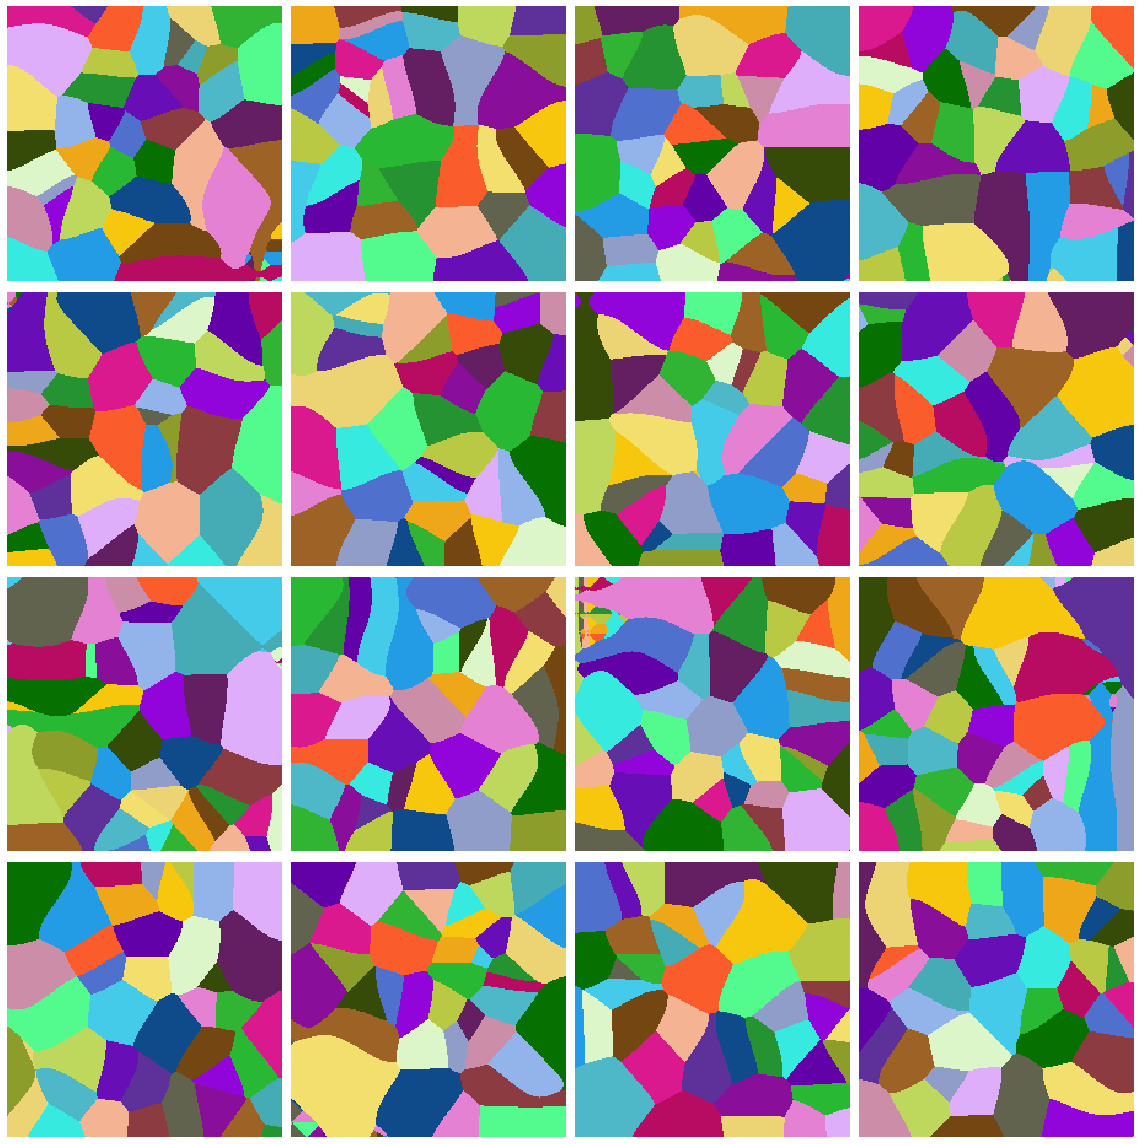

In [ ]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt

# Create random colormap
cmap = mpl.colors.ListedColormap(torch.rand(256**2,3).numpy())

# Params = Image dimensions + No. clusters
B,H,W = 16,224,224
C = 40
dev = torch.device('cpu')

# Get image dimensions
N = B*H*W

# Unravel indices for coordinates
shape = torch.tensor([B,H,W,1], device=dev)[:,None]
coefs = shape[1:].flipud().cumprod(dim=0).flipud()
byx = torch.div(torch.arange(N, device=dev)[None], coefs, rounding_mode='trunc') % shape[:-1]

# Normalize coordinates
y, x = byx[1:] / torch.tensor([H,W], device=byx.device)[:,None]
b = byx[0]

# Sample random centroids
sy,sx = torch.rand(2,B,C,device=byx.device)

# Set bandwith / sigma for kernel
std = C/(H*W)**.5

# One liner gaussian kernels
def gauss1d(x): return x.div(std).pow_(2).neg_().exp_()
def gauss2d(x, y): return (gauss1d(x) + gauss1d(y)) / 2

# Compute L2 distance
l2 = gauss2d(y[:,None] - sy[b], x[:,None] - sx[b])

print(l2.shape)

# Plot argmax
fig, ax = plt.subplots(4,4,figsize=(16,16))
for i, a in enumerate(ax.flatten()):
    a.matshow(l2.argmax(-1).view(B,H,W)[i].cpu(), cmap=cmap)
    a.axis('off')

plt.tight_layout()

torch.Size([802816, 64])


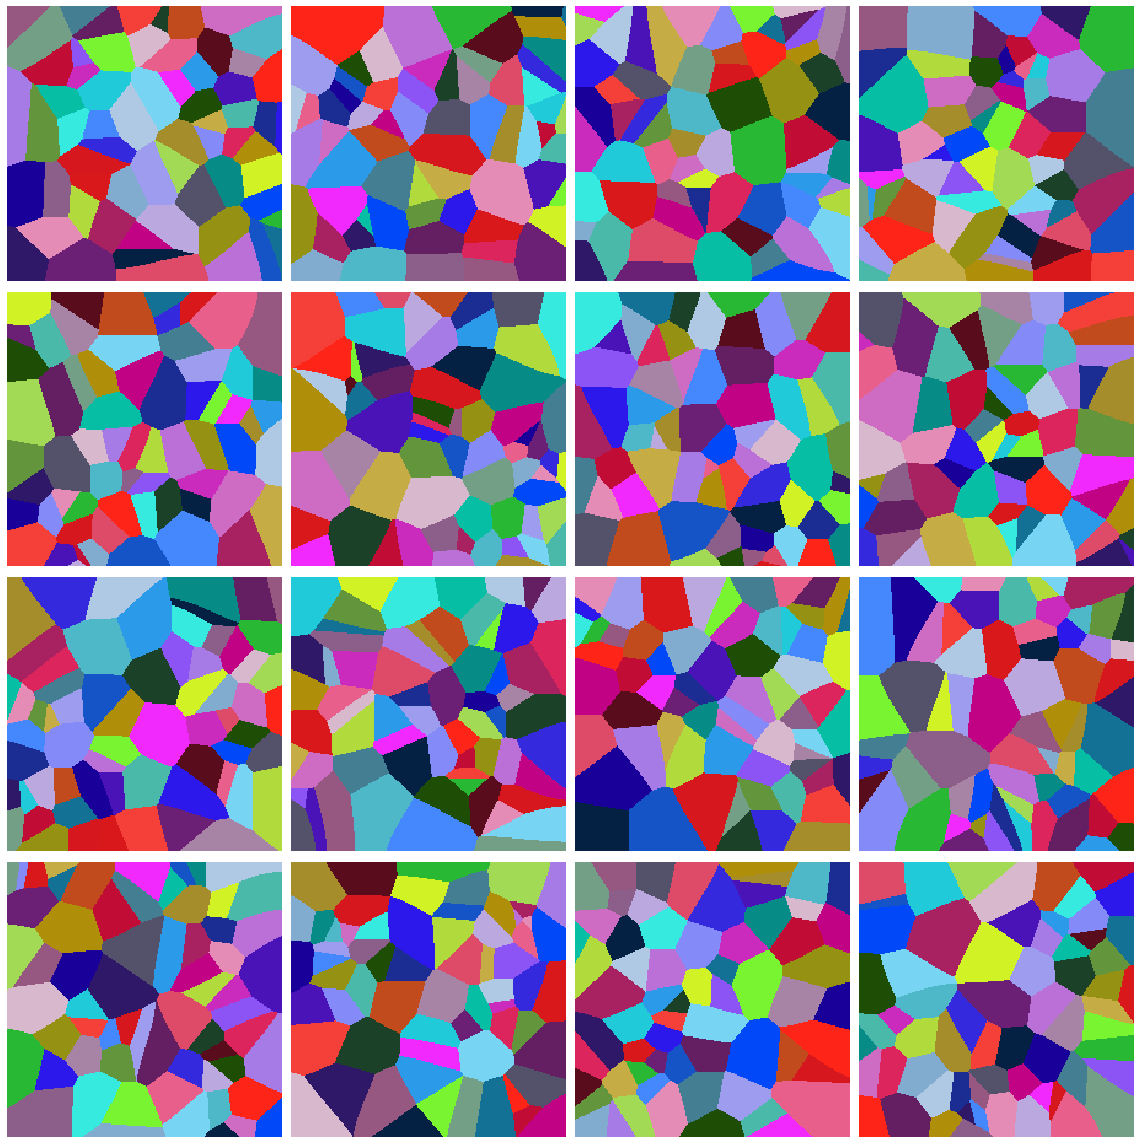

In [ ]:
import torch
import torch.nn as nn

class VoronoiPropagation(nn.Module):
    def __init__(self, num_clusters=64, height=224, width=224, device='cpu'):
        super(VoronoiPropagation, self).__init__()
        
        # Initialize parameters
        self.C = num_clusters
        self.H = height
        self.W = width
        self.device = torch.device(device)
        
        # Set bandwidth / sigma for kernel
        self.std = self.C / (self.H * self.W)**0.5
    
    def gauss1d(self, x):
        return x.div(self.std).pow_(2).neg_().exp_()
    
    def gauss2d(self, x, y):
        return (self.gauss1d(x) + self.gauss1d(y)) / 2

    def forward(self, x):
        B, C_in, H, W = x.shape  # Input image dimensions

        # Get total number of pixels
        N = B * H * W

        # Unravel indices for coordinates
        shape = torch.tensor([B, H, W, 1], device=self.device)[:, None]
        coefs = shape[1:].flipud().cumprod(dim=0).flipud()
        byx = torch.div(torch.arange(N, device=self.device)[None], coefs, rounding_mode='trunc') % shape[:-1]

        # Normalize coordinates
        y, x = byx[1:] / torch.tensor([H, W], device=byx.device)[:, None]
        b = byx[0]

        # Sample random centroids
        sy, sx = torch.rand(2, B, self.C, device=self.device)

        # Compute L2 distance with Gaussian kernel
        l2 = self.gauss2d(y[:, None] - sy[b], x[:, None] - sx[b])

        return l2

B, C_in, H, W = 16, 3, 224, 224
images = torch.rand(B, C_in, H, W)

model = VoronoiPropagation(num_clusters=64, height=224, width=224, device='cpu')
output = model(images)  # Output is the L2 distance with Gaussian kernel
print(output.shape)  # Should output shape (H * W, B, C)

# Plot argmax
fig, ax = plt.subplots(4,4,figsize=(16,16))
for i, a in enumerate(ax.flatten()):
    a.matshow(output.argmax(-1).view(B,H,W)[i].cpu(), cmap=cmap)
    a.axis('off')

plt.tight_layout()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import segmentation_models_pytorch as smp


class VoronoiPropagation(nn.Module):
    def __init__(self, num_clusters=64, height=224, width=224, device='cpu'):
        """
        Args:
            num_clusters (int): Number of clusters (centroids) to initialize.
            height (int): Height of the input image.
            width (int): Width of the input image.
            device (str): Device to run the model ('cpu' or 'cuda').
        """
        super(VoronoiPropagation, self).__init__()
        
        self.C = num_clusters
        self.H = height
        self.W = width
        self.device = torch.device(device)
        
        # self.unet = smp.Unet(encoder_name="efficientnet-b0",
        #                      encoder_weights="imagenet",  
        #                      in_channels=3,               
        #                      classes=3)   
        
        # Set bandwidth / sigma for kernel
        self.std = self.C / (self.H * self.W)**0.5
        
        self.convert_to_greyscale = torchvision.transforms.Grayscale(num_output_channels=1)

    def compute_gradient_map(self, x):
        # Sobel kernels for single-channel input
        sobel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], device=x.device, dtype=x.dtype)
        sobel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], device=x.device, dtype=x.dtype)
        
        # Apply Sobel filters
        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)
        
        # Compute gradient magnitude
        grad_map = torch.sqrt(grad_x.pow(2) + grad_y.pow(2))
        return grad_map

    def place_centroids_on_grid(self, batch_size):
        num_cols = int(math.sqrt(self.C * self.W / self.H))
        num_rows = int(math.ceil(self.C / num_cols))

        grid_spacing_y = self.H / num_rows
        grid_spacing_x = self.W / num_cols

        centroids = []
        for i in range(num_rows):
            for j in range(num_cols):
                if len(centroids) >= self.C:
                    break
                y = int((i + 0.5) * grid_spacing_y)
                x = int((j + 0.5) * grid_spacing_x)
                centroids.append([y, x])
            if len(centroids) >= self.C:
                break

        centroids = torch.tensor(centroids, device=self.device).float()
        return centroids.unsqueeze(0).repeat(batch_size, 1, 1)

    def find_nearest_minima(self, centroids, grad_map, neighborhood_size=10):
        updated_centroids = []
        B, _, _ = centroids.shape
        
        for batch_idx in range(B):
            updated_centroids_batch = []
            occupied_positions = set()
            for centroid in centroids[batch_idx]:
                y, x = centroid
                y_min = max(0, int(y) - neighborhood_size)
                y_max = min(self.H, int(y) + neighborhood_size)
                x_min = max(0, int(x) - neighborhood_size)
                x_max = min(self.W, int(x) + neighborhood_size)
                
                neighborhood = grad_map[batch_idx, 0, y_min:y_max, x_min:x_max]
                min_val = torch.min(neighborhood)
                min_coords = torch.nonzero(neighborhood == min_val, as_tuple=False)
                
                # Iterate over all minima to find an unoccupied one
                found = False
                for coord in min_coords:
                    new_y = y_min + coord[0].item()
                    new_x = x_min + coord[1].item()
                    position = (new_y, new_x)
                    if position not in occupied_positions:
                        occupied_positions.add(position)
                        updated_centroids_batch.append([new_y, new_x])
                        found = True
                        break
                if not found:
                    # If all minima are occupied, keep the original position
                    updated_centroids_batch.append([y.item(), x.item()])
            
            updated_centroids.append(torch.tensor(updated_centroids_batch, device=self.device))
        
        return torch.stack(updated_centroids, dim=0)

    def distance_weighted_propagation(self, centroids, grad_map, color_map, num_iters=50, gradient_weight=10.0, color_weight=10.0, edge_exponent=4.0): # gradient weight, color weight and edge exponent are all tuneable parameters 
        """
        Perform Voronoi-like propagation from centroids, guided by both the gradient map and color similarity.
        
        Args:
            centroids (Tensor): Initial centroid positions.
            grad_map (Tensor): Gradient magnitude map.
            color_map (Tensor): Input image for color similarity.
            num_iters (int): Number of iterations to perform propagation.
            gradient_weight (float): Weight for the gradient penalty.
            color_weight (float): Weight for the color similarity penalty.
            edge_exponent (float): Exponent to amplify edge gradients.
        
        Returns:
            Tensor: Final segmentation mask.
        """
        B, _, H, W = grad_map.shape
        mask = torch.full((B, H, W), fill_value=-1, device=grad_map.device)  # Label mask
        dist_map = torch.full((B, H, W), fill_value=float('inf'), device=grad_map.device)  # Distance map
        
        for batch_idx in range(B):
            for idx, (cy, cx) in enumerate(centroids[batch_idx]):
                mask[batch_idx, int(cy), int(cx)] = idx
                dist_map[batch_idx, int(cy), int(cx)] = 0  # Distance from centroid is 0 initially
        
        # 4-connected neighbors (dy, dx)
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        # Amplify the impact of the gradient map by multiplying it with a weight and applying a non-linear transformation
        weighted_grad_map = (grad_map ** edge_exponent) * gradient_weight

        # Perform propagation with both gradient penalties and color similarity
        for _ in range(num_iters):
            for dy, dx in directions:
                # Shift the distance map in each direction
                shifted_dist = torch.roll(dist_map, shifts=(dy, dx), dims=(1, 2))
                shifted_mask = torch.roll(mask, shifts=(dy, dx), dims=(1, 2))
                
                # Calculate color distance between current pixel and centroid it is being propagated from
                color_diff = torch.abs(color_map - torch.roll(color_map, shifts=(dy, dx), dims=(2, 3))).sum(dim=1)  # Sum over color channels

                # Add the gradient map value as a weighted penalty to the distance
                weighted_dist = shifted_dist + weighted_grad_map[:, 0, :, :] + color_diff * color_weight
                
                # Update the mask and distance map where the new combined distance is smaller
                update_mask = weighted_dist < dist_map
                dist_map[update_mask] = weighted_dist[update_mask]
                mask[update_mask] = shifted_mask[update_mask]
        
        return mask
        
    def forward(self, x):
        B, C_in, H, W = x.shape
        
        if C_in == 3:
            grayscale_image = self.convert_to_greyscale(x)
        else:
            grayscale_image = x
        
        # Compute the gradient map from grayscale image
        grad_map = self.compute_gradient_map(grayscale_image)
        
        # Place centroids on a grid
        centroids = self.place_centroids_on_grid(B)
        
        # Move centroids to nearest local minima
        centroids = self.find_nearest_minima(centroids, grad_map)
        
        # Use the color map (the original image) to guide propagation
        # spixel_features = self.unet(x)
        
        # Perform distance-weighted propagation with both gradient and color guidance
        mask = self.distance_weighted_propagation(centroids, grad_map, x)
        
        # return grad_map, centroids, mask, spixel_features
        return grad_map, centroids, mask# , x
    
cmap = mpl.colors.ListedColormap(torch.rand(256**2, 3).numpy())

def plot_gradient_map(grad_map):
    plt.figure(figsize=(10, 10))
    plt.imshow(grad_map[0, 0].cpu().numpy(), cmap='gray')
    plt.colorbar()
    plt.title('Gradient Map')
    plt.show()

def plot_centroids(centroids, grad_map):
    plt.figure(figsize=(10, 10))
    plt.imshow(grad_map[0, 0].cpu().numpy(), cmap='gray')
    centroids_np = centroids[0].cpu().numpy()
    plt.scatter(centroids_np[:, 1], centroids_np[:, 0], color='red', marker='x')
    plt.title('Centroids on Gradient Map')
    plt.show()
  
def plot_mask(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask[0].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Superpixel Mask')
    plt.show()

# Example usage with plotting
voronoi_model = VoronoiPropagation(num_clusters=256, height=224, width=224, device='cuda')
input_image = torch.rand((1, 3, 224, 224), device='cuda')  # Example input image

# Get the gradient map, centroids, and output mask
grad_map, centroids, output_mask = voronoi_model(input_image)

print(output_mask.shape)


# Plot the gradient map
plot_gradient_map(grad_map)

# Plot the centroids on the gradient map
plot_centroids(centroids, grad_map)

# Plot the mask
plot_mask(output_mask)

AssertionError: torch.Size([1, 3, 224, 224])

In [8]:
from skimage.morphology import thin
import numpy as np

def plot_segmentation_boundaries(image_np, output_mask, figsize=(15, 15)):
    """
    Plot the boundaries of the segmentation over the original image.
    Uses pixel comparison to detect boundaries and applies thinning.
    """
    output_mask_np = output_mask[0].cpu().numpy()

    # Find boundaries by comparing neighboring pixels
    boundaries = np.zeros_like(output_mask_np)
    boundaries[1:, :] = np.logical_or(boundaries[1:, :], output_mask_np[1:, :] != output_mask_np[:-1, :])  # Compare vertically
    boundaries[:, 1:] = np.logical_or(boundaries[:, 1:], output_mask_np[:, 1:] != output_mask_np[:, :-1])  # Compare horizontally

    # Apply thinning to ensure boundaries are only 1 pixel wide
    boundaries = thin(boundaries)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.imshow(image_np)

    ax.contour(boundaries, colors='red', linewidths=0.7)

    ax.set_title('Image with Segmentation Boundaries (Thinned)')
    ax.axis('off')

    plt.show()

(321, 481)
256


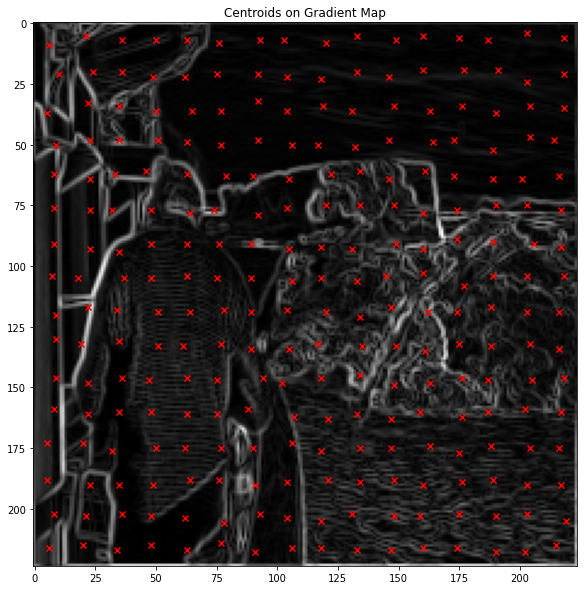

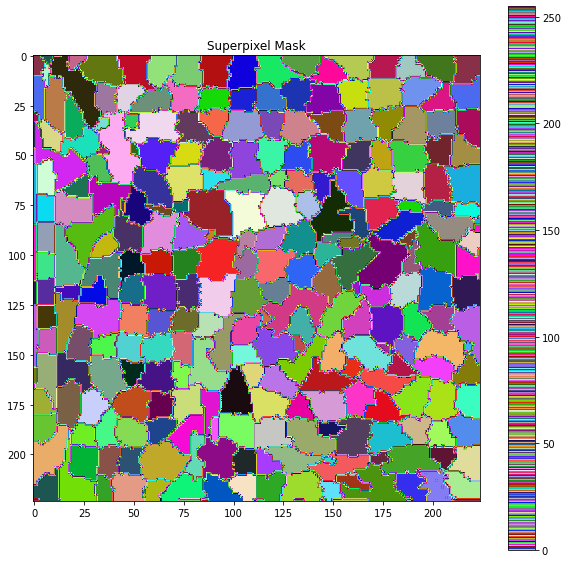

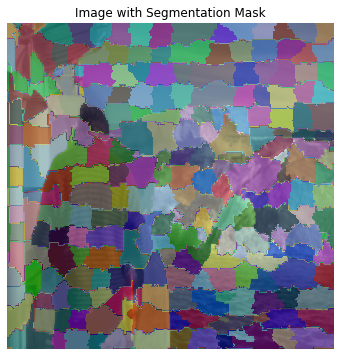

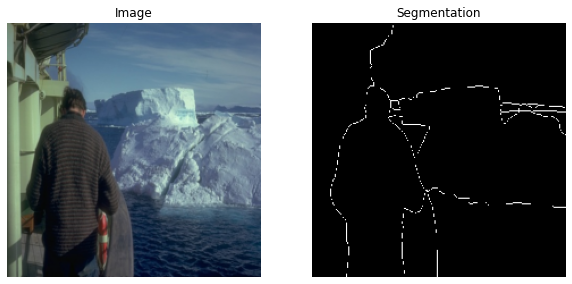

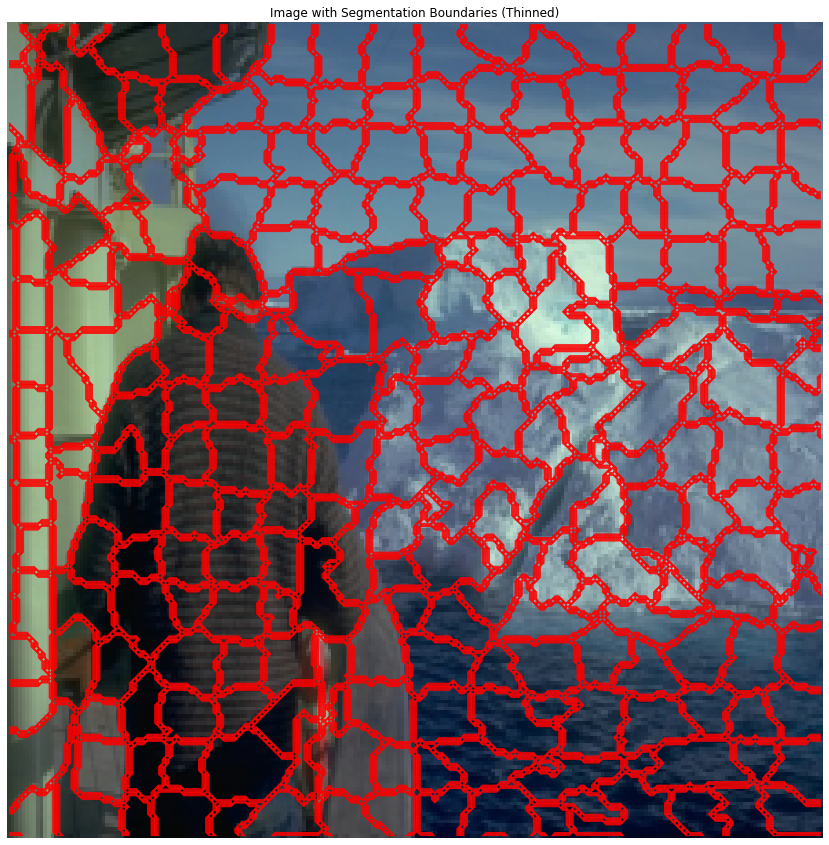

In [14]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images', split)
        self.ground_truth_dir = os.path.join(root_dir, 'ground_truth', split)
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        gt_name = os.path.join(self.ground_truth_dir, self.image_files[idx].replace('.jpg', '.mat'))
        gt_data = sio.loadmat(gt_name)
        ground_truth = gt_data['groundTruth'][0][0][0][0][1]

        
        #print(ground_truth)
        print(ground_truth.shape)
        # print(ground_truth[0, 0])
        # print(ground_truth[0, 0]['Segmentation'])
        segmentation = ground_truth
        
        if isinstance(segmentation, np.ndarray) and segmentation.shape == (1, 1):
            segmentation = segmentation[0, 0]
        
        segmentation = Image.fromarray(segmentation)
        segmentation = segmentation.resize((224, 224), Image.NEAREST)
        
        segmentation = np.array(segmentation, dtype=np.int64)

        segmentation = torch.tensor(segmentation, dtype=torch.long)
        
        return image, segmentation

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

dataset = BSDS500Dataset(root_dir=r'D:\Data\BSDS500\data', split='train', transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

import random
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

random_idx = random.randint(0, len(dataset) - 1)

image, segmentation = dataset[random_idx]

grad_map, centroids, output_mask = voronoi_model(image.unsqueeze(0).to("cuda"))

cmap = mpl.colors.ListedColormap(torch.rand(256**2, 3).numpy())

plot_centroids(centroids, grad_map)

plot_mask(output_mask)

image_np = image.permute(1, 2, 0).numpy()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

output_mask_np = output_mask[0].cpu().numpy()

cmap = mpl.colors.ListedColormap(torch.rand(224, 3).numpy())  # You can customize the colormap if desired

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(image_np)

# Overlay
ax.imshow(output_mask_np, cmap=cmap, alpha=0.5)  
ax.set_title('Image with Segmentation Mask')
ax.axis('off')

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image_np)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(segmentation, cmap='gray')
ax[1].set_title('Segmentation')
ax[1].axis('off')

plt.show()

plot_segmentation_boundaries(image_np, output_mask)

In [ ]:
def explained_variance_batch(image_batch, superpixel_labels_batch):
    batch_size, num_channels, height, width = image_batch.shape
    explained_variance_scores = []

    for i in range(batch_size):
        image = image_batch[i]  # Shape: (C, H, W)
        superpixel_labels = superpixel_labels_batch[i]  # Shape: (H, W)

        # Ensure superpixel_labels is in shape (H, W)
        superpixel_labels = superpixel_labels.squeeze().to(image.device)

        # Flatten image and labels for computation
        image_flat = image.view(num_channels, height * width)
        labels_flat = superpixel_labels.view(height * width)

        # Compute total variance of the image across all channels
        total_variance = image_flat.var(dim=1, unbiased=False).mean().item()

        # Proceed to compute within-superpixel variance (homogeneity_score)
        unique_labels = superpixel_labels.unique()
        num_superpixels = unique_labels.size(0)

        pixel_sums = torch.zeros((num_superpixels, num_channels), device=image.device)
        pixel_squares = torch.zeros((num_superpixels, num_channels), device=image.device)
        pixel_counts = torch.zeros(num_superpixels, device=image.device)

        for j, label in enumerate(unique_labels):
            mask = (labels_flat == label)
            pixel_sums[j] = image_flat[:, mask].sum(dim=1)
            pixel_squares[j] = (image_flat[:, mask] ** 2).sum(dim=1)
            pixel_counts[j] = mask.sum()

        pixel_means = pixel_sums / pixel_counts.unsqueeze(1)
        pixel_variances = (pixel_squares / pixel_counts.unsqueeze(1)) - (pixel_means ** 2)
        within_variance = pixel_variances.mean().item()

        # Compute explained variance
        explained_variance = 1 - (within_variance / total_variance)
        explained_variance_scores.append(explained_variance)

    return explained_variance_scores
print(output_mask.shape)
# Get the unique values
unique_values = torch.unique(output_mask)

# Get the number of unique values
num_unique_values = unique_values.numel()
print(num_unique_values)
explained_variance_batch(image.unsqueeze(0), output_mask)

torch.Size([1, 224, 224])
192


[0.8527334765207089]

(481, 321)
(321, 481)
(481, 321)
(481, 321)
(321, 481)
(321, 481)
(481, 321)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(481, 321)


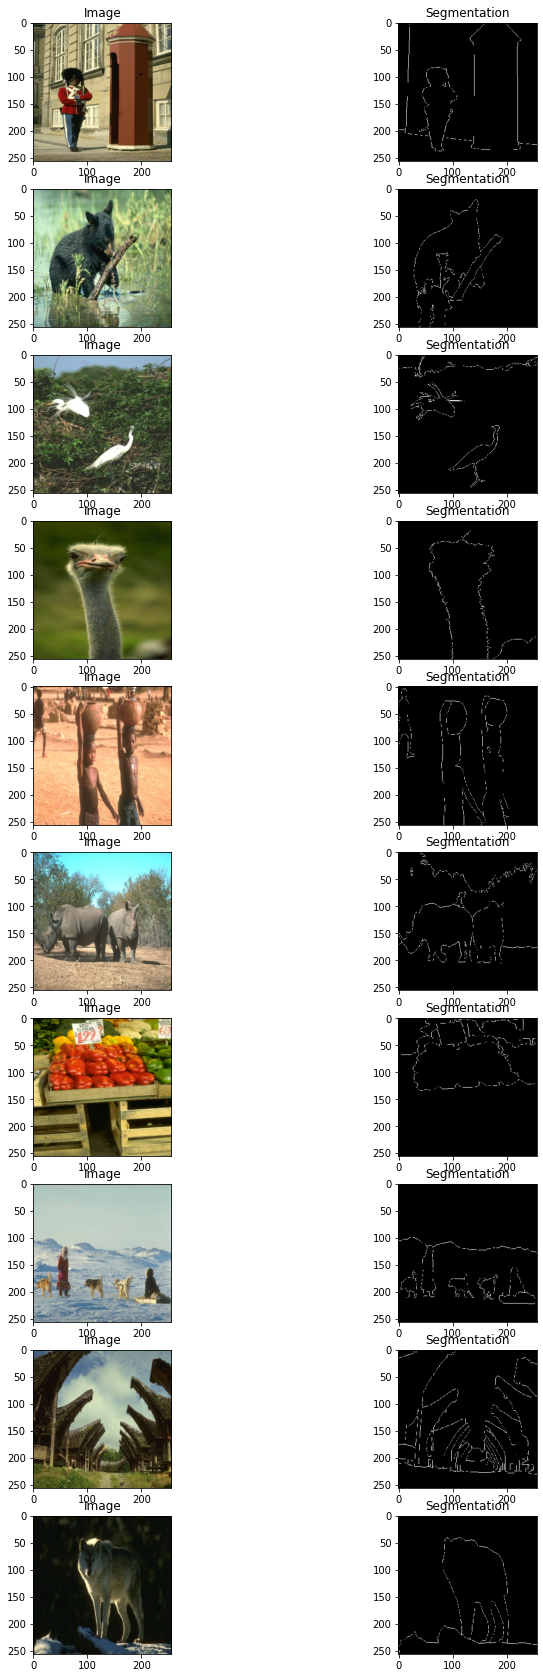

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images', split)
        self.ground_truth_dir = os.path.join(root_dir, 'ground_truth', split)
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        gt_name = os.path.join(self.ground_truth_dir, self.image_files[idx].replace('.jpg', '.mat'))
        gt_data = sio.loadmat(gt_name)
        ground_truth = gt_data['groundTruth'][0][0][0][0][1]

        
        #print(ground_truth)
        print(ground_truth.shape)
        # print(ground_truth[0, 0])
        # print(ground_truth[0, 0]['Segmentation'])
        segmentation = ground_truth
        
        if isinstance(segmentation, np.ndarray) and segmentation.shape == (1, 1):
            segmentation = segmentation[0, 0]
        
        segmentation = Image.fromarray(segmentation)
        segmentation = segmentation.resize((256, 256), Image.NEAREST)
        
        segmentation = np.array(segmentation, dtype=np.int64)
        
        segmentation = torch.tensor(segmentation, dtype=torch.long)
        
        return image, segmentation

transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

dataset = BSDS500Dataset(root_dir=r'D:\Data\BSDS500\data', split='train', transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

def plot_images_with_segmentations(dataloader, num_images=4):
    images_shown = 0
    plt.figure(figsize=(12, num_images * 3))
    for i, (images, segmentations) in enumerate(dataloader):
        for j in range(images.shape[0]):
            if images_shown >= num_images:
                plt.show()
                return

            image = images[j].permute(1, 2, 0)  
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]) 
            image = image.numpy()
            segmentation = segmentations[j].numpy()

            plt.subplot(num_images, 2, 2 * images_shown + 1)
            plt.imshow(image)
            plt.title('Image')

            plt.subplot(num_images, 2, 2 * images_shown + 2)
            plt.imshow(segmentation, cmap='gray')
            plt.title('Segmentation')

            images_shown += 1

    plt.show()

plot_images_with_segmentations(dataloader, num_images=10)

In [ ]:
import scipy.io as sio

mat_file_path = r"D:\Data\BSDS500\data\ground_truth\test\3063.mat"
data = sio.loadmat(mat_file_path)

ground_truth = data['groundTruth']

print(f"Ground Truth Structure: {ground_truth.shape}")

first_gt = ground_truth[0, 0]

print(f"Fields in first ground truth: {first_gt.dtype.names}")

segmentation = first_gt['Segmentation'][0, 0]
boundaries = first_gt['Boundaries'][0, 0]

print("Segmentation shape:", segmentation.shape)
print("Boundaries shape:", boundaries.shape)

print("Segmentation array:", segmentation)
print("Boundaries array:", boundaries)

Ground Truth Structure: (1, 6)
Fields in first ground truth: ('Segmentation', 'Boundaries')
Segmentation shape: (321, 481)
Boundaries shape: (321, 481)
Segmentation array: [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
Boundaries array: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
ground_truth = data['groundTruth']

print(f"Ground Truth Structure: {ground_truth.shape}")

for i in range(ground_truth.shape[1]):
    annotator_data = ground_truth[0, i]
    segmentation = annotator_data['Segmentation'][0, 0]
    boundaries = annotator_data['Boundaries'][0, 0]

    print(f"Annotation {i + 1}:")
    print(f"  Segmentation shape: {segmentation.shape}")
    print(f"  Boundaries shape: {boundaries.shape}")
    print(f"  Unique segments in this annotation: {len(np.unique(segmentation))}")
    print(f"  Number of boundary pixels: {np.sum(boundaries)}")

Ground Truth Structure: (1, 6)
Annotation 1:
  Segmentation shape: (321, 481)
  Boundaries shape: (321, 481)
  Unique segments in this annotation: 3
  Number of boundary pixels: 992
Annotation 2:
  Segmentation shape: (321, 481)
  Boundaries shape: (321, 481)
  Unique segments in this annotation: 2
  Number of boundary pixels: 991
Annotation 3:
  Segmentation shape: (321, 481)
  Boundaries shape: (321, 481)
  Unique segments in this annotation: 2
  Number of boundary pixels: 1014
Annotation 4:
  Segmentation shape: (321, 481)
  Boundaries shape: (321, 481)
  Unique segments in this annotation: 10
  Number of boundary pixels: 1239
Annotation 5:
  Segmentation shape: (321, 481)
  Boundaries shape: (321, 481)
  Unique segments in this annotation: 17
  Number of boundary pixels: 3805
Annotation 6:
  Segmentation shape: (321, 481)
  Boundaries shape: (321, 481)
  Unique segments in this annotation: 10
  Number of boundary pixels: 1197


In [ ]:
import torch

def compute_affinity_and_labels(model_output, pixel_features):
    """
    Convert model output to abs_affinity, hard_labels, and spixel_features.

    Args:
        model_output: torch.Tensor
            A tensor of shape (batch_size, n_segments, height, width), 
            representing the affinity of each pixel to each segment.
        pixel_features: torch.Tensor
            A tensor of shape (batch_size, channels, height, width), 
            representing the features of each pixel.
    
    Returns:
        abs_affinity: torch.Tensor
            A tensor of shape (batch_size, height * width, n_segments), representing the pixel-to-segment affinities.
        hard_labels: torch.Tensor
            A tensor of shape (batch_size, height * width), representing the hard labels (segment assignments) for each pixel.
        spixel_features: torch.Tensor
            A tensor of shape (batch_size, n_segments, channels), representing the aggregated superpixel features.
    """
    batch_size, n_segments, height, width = model_output.shape
    _, channels, _, _ = pixel_features.shape
    
    # Reshape model output to compute abs_affinity
    abs_affinity = model_output.view(batch_size, n_segments, height * width)  # (B, n_segments, H * W)
    abs_affinity = abs_affinity.permute(0, 2, 1).contiguous()  # (B, H * W, n_segments)
    
    # Compute hard labels (most likely segment for each pixel)
    hard_labels = torch.argmax(abs_affinity, dim=2)  # (B, H * W)
    
    # Reshape pixel features for matrix multiplication
    pixel_features = pixel_features.view(batch_size, channels, height * width)  # (B, C, H * W)
    permuted_pixel_features = pixel_features.permute(0, 2, 1).contiguous()  # (B, H * W, C)
    
    # Compute spixel_features by taking the weighted average of pixel features for each segment
    abs_affinity_normalized = abs_affinity / (abs_affinity.sum(dim=1, keepdim=True) + 1e-16)  # Normalize affinities
    spixel_features = torch.bmm(abs_affinity_normalized.permute(0, 2, 1), permuted_pixel_features)  # (B, n_segments, C)

    return abs_affinity, hard_labels, spixel_features

# Example usage:
batch_size = 2
n_segments = 5
height = 16
width = 16
channels = 3

# Dummy model output (affinity map) and pixel features
model_output = torch.rand(batch_size, n_segments, height, width)
pixel_features = torch.rand(batch_size, channels, height, width)

# Convert model output into abs_affinity, hard_labels, and spixel_features
abs_affinity, hard_labels, spixel_features = compute_affinity_and_labels(model_output, pixel_features)

print("abs_affinity shape:", abs_affinity.shape)  # (batch_size, height * width, n_segments)
print("hard_labels shape:", hard_labels.shape)  # (batch_size, height * width)
print("spixel_features shape:", spixel_features.shape)  # (batch_size, n_segments, channels)

abs_affinity shape: torch.Size([2, 256, 5])
hard_labels shape: torch.Size([2, 256])
spixel_features shape: torch.Size([2, 5, 3])
